In [23]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor

Считывание датасета:

In [24]:
df = pd.read_csv('NEW-DATA-1.T15.txt', sep=" ")
df.drop(['#','1:Date'], axis=1, inplace=True)
df = df.iloc[:, 2:]

Первым делом необходимо определить, какой параметр использовать в качестве результата предсказаний. Для этого построим корреляционную матрицу:

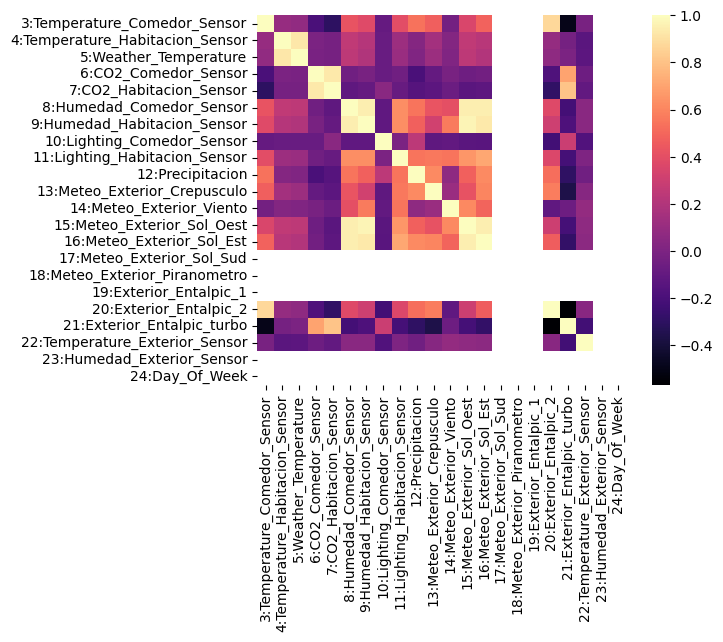

In [25]:
corrmat = df.corr()
sns.heatmap(corrmat, cmap='magma', square=True)
plt.show()

Выберем переменную, которая имеет наибольшую линейную зависимость с большинством параметров:

In [26]:
column_to_predict = corrmat.columns[0]
for column in corrmat.columns:
    if corrmat[column].sum() > corrmat[column_to_predict].abs().sum():
        column_to_predict = column
print(f'Колонка, значения которой будут предсказываться: {column_to_predict}')

Колонка, значения которой будут предсказываться: 8:Humedad_Comedor_Sensor


Теперь необходимо выбрать переменные, которые имеют наибольшую линейную зависимость с предсказываемым параметром:

In [27]:
min_correlation = 0.8
features_condition = (abs(corrmat[column_to_predict]) >= min_correlation) & (corrmat.columns != column_to_predict)
features = corrmat.columns[features_condition]
x_dataframe = df[features]
print(f'Колонки с лучшей линейной зависимостью: {features.values}')

Колонки с лучшей линейной зависимостью: ['9:Humedad_Habitacion_Sensor' '15:Meteo_Exterior_Sol_Oest'
 '16:Meteo_Exterior_Sol_Est']


1) Написать программу, которая разделяет исходную выборку на обучающую и тестовую (training set, test set). Использовать стандартные функции (train_test_split и др. нельзя).

In [28]:
x_data = np.array(x_dataframe)
y_data = np.array(df[column_to_predict])

val_size = 0.2
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=val_size)

2. С использованием библиотеки scikit-learn обучить модель линейной регрессии по обучающей выборке.

In [29]:
regr = linear_model.LinearRegression()
regr.fit(x_data, y_data)

LinearRegression()

3. Проверьте точность модели из тестового набора с помощью r2_score.

In [30]:
y_val_pred = regr.predict(x_val)
r2_val = r2_score(y_val, y_val_pred)
print(f'Коэффициент детерминации: {r2_val}')

Коэффициент детерминации: 0.9297272849829932


Для наглядности, отобразим предсказания на нулевую ось:

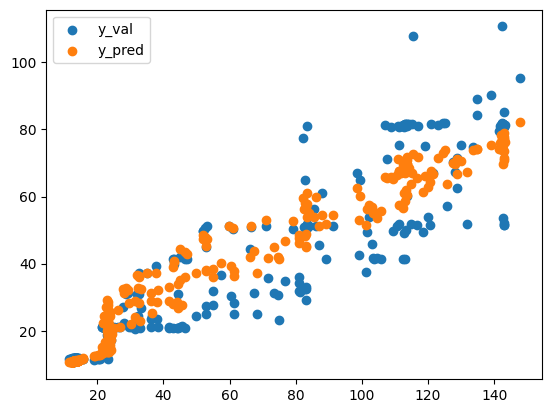

In [31]:

plt.scatter(x_val.T[0], y_val, label="y_val")
plt.scatter(x_val.T[0], y_val_pred, label="y_pred")

plt.legend()

4. Постройте модель, используя полиномиальную функцию. Постройте графики зависимости точности (r2_score) от степени полиномиальной функции для обучающего набора и тестового набора (кривая валидации).

Лучшее значение степени: 3. Лучшее значение r2: 0.9753092595957448


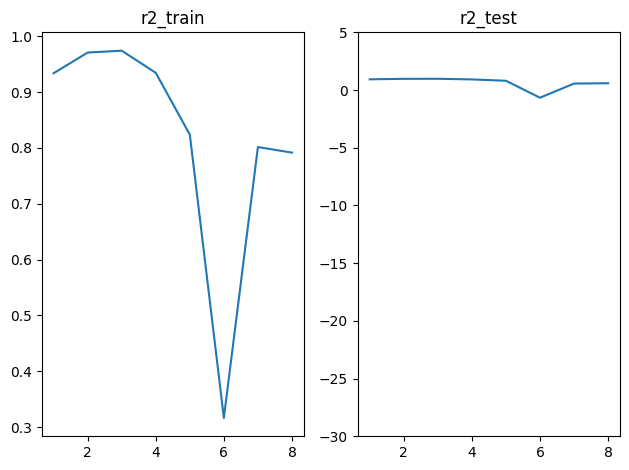

In [32]:
max_degree = 8

r2_train = [0] * max_degree
r2_val = [0] * max_degree

fig, axs = plt.subplots(1, 2)

best_degree = 1
best_r2_score = -1e20
for id, polynomial_degree in enumerate(range(1, max_degree + 1)):
    polynomial_features  = PolynomialFeatures(degree=polynomial_degree, include_bias=False)
    linear_regression = linear_model.LinearRegression()

    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )

    pipeline.fit(x_train, y_train)

    y_train_pred = pipeline.predict(x_train)
    y_val_pred = pipeline.predict(x_val)

    r2_train[id] = r2_score(y_train, y_train_pred)
    r2_val[id] = r2_score(y_val, y_val_pred)

    if r2_val[id] >= best_r2_score:
        best_r2_score = r2_val[id]
        best_degree = polynomial_degree

print(f'Лучшее значение степени: {best_degree}. Лучшее значение r2: {best_r2_score}')

axs[0].plot(np.linspace(1, max_degree, max_degree), r2_train)
axs[0].set_title('r2_train')

axs[1].plot(np.linspace(1, max_degree, max_degree), r2_val)
axs[1].set_title('r2_test')

plt.ylim(-30, 5)

fig.tight_layout()
plt.show()



Можно заметить, что из-за переобучения, вызванного слишком большим значением степени полинома, полиномная регрессия начинает выдавать некорректные результаты.

5) Создайте модель, используя регуляризацию. Выберите один из «Lasso» или «Ridge». На основе экспериментов подберите параметры для регуляризации. Постройте графики с зависимостью ошибки (r2_score) от коэффициента регуляризации для обучающего набора данных и набора тестовых данных (кривая проверки).

Лучшее значение параметра alpha: 1.0. Лучшее значение r2: 0.742017459574721


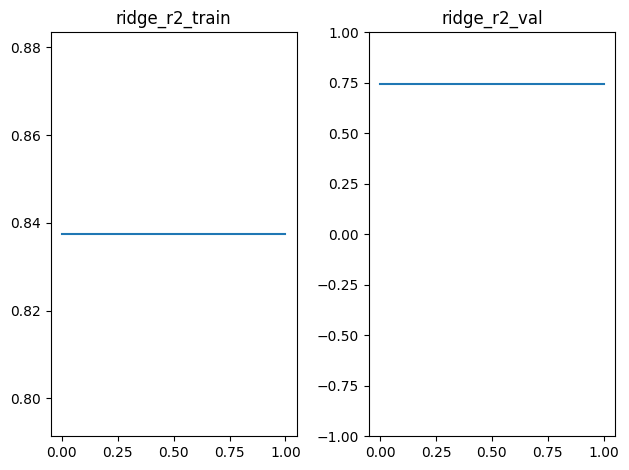

In [33]:
ridge_regression_degree = 8
count_alpha = 20

ridge_r2_train = [0] * count_alpha
ridge_r2_val = [0] * count_alpha

fig, axs = plt.subplots(1, 2)

best_alpha = 0
best_r2_score = -1e20
for id, alpha_factor in enumerate(np.linspace(0, 1, count_alpha)):
    polynomial_features  = PolynomialFeatures(degree=ridge_regression_degree, include_bias=False)
    linear_regression = linear_model.Ridge(alpha=alpha_factor)

    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )

    pipeline.fit(x_train, y_train)

    y_train_pred = pipeline.predict(x_train)
    y_val_pred = pipeline.predict(x_val)

    ridge_r2_train[id] = r2_score(y_train, y_train_pred)
    ridge_r2_val[id] = r2_score(y_val, y_val_pred)

    if ridge_r2_val[id] >= best_r2_score:
        best_r2_score = ridge_r2_val[id]
        best_alpha = alpha_factor

print(f'Лучшее значение параметра alpha: {best_alpha}. Лучшее значение r2: {best_r2_score}')

axs[0].plot(np.linspace(0, 1, count_alpha), ridge_r2_train)
axs[0].set_title('ridge_r2_train')

axs[1].plot(np.linspace(0, 1, count_alpha), ridge_r2_val)
axs[1].set_title('ridge_r2_val')

plt.ylim(-1, 1)

fig.tight_layout()
plt.show()